Take 300 images and make an avi

In [2]:
import PySpin
import cv2

def configure_camera(cam):
    # Configure camera settings as needed
    cam.AcquisitionMode.SetValue(PySpin.AcquisitionMode_Continuous)
    cam.PixelFormat.SetValue(PySpin.PixelFormat_Mono8)  # Example: Mono8 for 8-bit grayscale

def acquire_video(cam, num_frames, output_file):
    # Create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fps = 30  # Adjust as needed
    frame_width = int(cam.Width())
    frame_height = int(cam.Height())
    out = cv2.VideoWriter(output_file, fourcc, fps, (frame_width, frame_height), isColor=False)

    try:
        # Start the acquisition
        cam.BeginAcquisition()

        # Create OpenCV window for display
        cv2.namedWindow('Video', cv2.WINDOW_NORMAL)

        # Capture and save frames
        for i in range(num_frames):
            # Retrieve next image
            image_result = cam.GetNextImage()

            if image_result.IsIncomplete():
                print('Image incomplete: ', image_result.GetImageStatus())
            else:
                # Convert image to numpy array
                frame = image_result.GetNDArray()

                # Display frame
                cv2.imshow('Video', frame)

                # Write frame to video file
                out.write(frame)

                # Wait for a short time and check for 'q' key press to exit
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

            # Release image
            image_result.Release()

    finally:
        # End acquisition
        cam.EndAcquisition()

        # Release VideoWriter and destroy OpenCV window
        out.release()
        cv2.destroyAllWindows()

if __name__ == '__main__':
    system = PySpin.System.GetInstance()
    cam_list = system.GetCameras()

    try:
        if cam_list.GetSize() == 0:
            raise ValueError("No cameras found!")

        # Assume one camera for simplicity
        cam = cam_list.GetByIndex(0)

        # Initialize camera
        cam.Init()

        # Configure camera settings
        configure_camera(cam)

        # Acquire and save video
        num_frames = 300  # Number of frames to capture
        output_file = 'output.avi'  # Output video file
        acquire_video(cam, num_frames, output_file)

        # Deinitialize camera
        cam.DeInit()

    except PySpin.SpinnakerException as ex:
        print('Error: %s' % ex)
        exit_code = 1

    finally:
        # Release camera and system
        del cam
        cam_list.Clear()
        system.ReleaseInstance()


Error: Spinnaker: GenICam::AccessException= Node is not writable. : AccessException thrown in node 'PixelFormat' while calling 'PixelFormat.SetIntValue()' (file 'EnumerationT.h', line 83) [-2006]


Arduino Trigger Pointgrey

In [3]:
import PySpin
import cv2
import serial  # Import serial library for Arduino communication

# Serial communication setup with Arduino
ser = serial.Serial('COM22', 9600)  # Adjust port and baud rate as needed (COM22 for Windows)

def configure_camera(cam):
    # Configure camera settings as needed
    try:
        # Check if PixelFormat node is writable
        if PySpin.IsWritable(cam.PixelFormat):
            cam.PixelFormat.SetValue(PySpin.PixelFormat_Mono8)
        else:
            print("PixelFormat node not writable")
    except PySpin.SpinnakerException as ex:
        print(f"Error setting PixelFormat: {ex}")

    # Additional settings if needed
    cam.AcquisitionMode.SetValue(PySpin.AcquisitionMode_Continuous)

def acquire_video(cam, num_frames, output_file):
    # Create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fps = 30  # Adjust as needed
    frame_width = int(cam.Width())
    frame_height = int(cam.Height())
    out = cv2.VideoWriter(output_file, fourcc, fps, (frame_width, frame_height), isColor=False)

    cv2.namedWindow('Live Video', cv2.WINDOW_NORMAL)  # Create a resizable window

    try:
        # Start the acquisition
        cam.BeginAcquisition()

        # Capture and save frames
        for i in range(num_frames):
            # Wait for square wave from Arduino (assumes Arduino controls timing)
            while ser.in_waiting == 0:
                pass
            
            # Read Arduino message
            arduino_msg = ser.readline().strip().decode('utf-8')
            if arduino_msg == 'Square wave triggered':
                # Retrieve next image
                image_result = cam.GetNextImage()

                if image_result.IsIncomplete():
                    print('Image incomplete: ', image_result.GetImageStatus())
                else:
                    # Convert image to numpy array
                    frame = image_result.GetNDArray()

                    # Display frame in real-time
                    cv2.imshow('Live Video', frame)
                    cv2.waitKey(1)  # Required to update the display

                    # Write frame to video file
                    out.write(frame)

                # Release image
                image_result.Release()

    finally:
        # End acquisition
        cam.EndAcquisition()

        # Release VideoWriter
        out.release()

        # Close OpenCV windows
        cv2.destroyAllWindows()

def main():
    system = PySpin.System.GetInstance()
    cam_list = system.GetCameras()

    try:
        if cam_list.GetSize() == 0:
            raise ValueError("No cameras found!")

        # Assume one camera for simplicity
        cam = cam_list.GetByIndex(0)

        # Initialize camera
        cam.Init()

        # Configure camera settings
        configure_camera(cam)

        # Acquire and save video
        num_frames = 300  # Number of frames to capture
        output_file = 'output.avi'  # Output video file
        acquire_video(cam, num_frames, output_file)

        # Deinitialize camera
        cam.DeInit()

    except PySpin.SpinnakerException as ex:
        print('Error: %s' % ex)
        exit_code = 1

    finally:
        # Release camera and system
        del cam
        cam_list.Clear()
        system.ReleaseInstance()
        ser.close()  # Close serial communication with Arduino

if __name__ == '__main__':
    main()


PixelFormat node not writable


Justin Blaber Protocol

In [4]:
import PySpin
 
# Set camera serial numbers
serial_1 = '16290112'

# Get system
system = PySpin.System.GetInstance()
 
# Get camera list
cam_list = system.GetCameras()
 
# Get cameras by serial
cam_1 = cam_list.GetBySerial(serial_1)
 
# Initialize cameras
cam_1.Init()

cam_1.TriggerMode.SetValue(PySpin.TriggerMode_Off)
cam_1.TriggerSource.SetValue(PySpin.TriggerSource_Line3)
cam_1.TriggerOverlap.SetValue(PySpin.TriggerOverlap_ReadOut)
cam_1.TriggerMode.SetValue(PySpin.TriggerMode_On)

# Set acquisition mode to acquire a single frame, this ensures acquired images are sync'd since camera 2 and 3 are setup to be triggered
cam_1.AcquisitionMode.SetValue(PySpin.AcquisitionMode_SingleFrame)

# Start acquisition; note that secondary cameras have to be started first so acquisition of primary camera triggers secondary cameras.
cam_1.BeginAcquisition()

# Acquire images
image_1 = cam_1.GetNextImage()

# Save images
image_1.Save('cam_1.png')

# Release images
image_1.Release()

# end acquisition
cam_1.EndAcquisition()

In [2]:
import PySpin

# Set camera serial number
serial_1 = '16290112'

try:
    # Initialize system
    system = PySpin.System.GetInstance()

    # Retrieve list of cameras
    cam_list = system.GetCameras()

    # Check if no cameras are found
    if cam_list.GetSize() == 0:
        raise Exception("No cameras found!")

    # Get camera by serial number
    cam_1 = cam_list.GetBySerial(serial_1)

    # Initialize camera
    cam_1.Init()

    # Set trigger mode and source
    cam_1.TriggerMode.SetValue(PySpin.TriggerMode_Off)
    cam_1.TriggerSource.SetValue(PySpin.TriggerSource_Line3)
    cam_1.TriggerOverlap.SetValue(PySpin.TriggerOverlap_ReadOut)
    cam_1.TriggerMode.SetValue(PySpin.TriggerMode_On)

    # Set acquisition mode to acquire a single frame
    cam_1.AcquisitionMode.SetValue(PySpin.AcquisitionMode_SingleFrame)

    # Start acquisition
    cam_1.BeginAcquisition()

    # Acquire image
    image_1 = cam_1.GetNextImage()

    # Save image
    image_1.Save('cam_1.png')

    # Release image
    image_1.Release()

    # End acquisition
    cam_1.EndAcquisition()

    # Deinitialize camera
    cam_1.DeInit()

except PySpin.SpinnakerException as ex:
    print('Error: %s' % ex)

except Exception as ex:
    print('General error: %s' % ex)

finally:
    # Release camera
    del cam_1

    # Clear camera list and release system instance
    cam_list.Clear()
    system.ReleaseInstance()


In [2]:
import PySpin
import cv2
import numpy as np

# Set camera serial number
serial_1 = '16290112'

def configure_camera(cam):
    # Set trigger mode and source
    cam.TriggerMode.SetValue(PySpin.TriggerMode_Off)  # Ensure trigger mode is off initially
    cam.TriggerSource.SetValue(PySpin.TriggerSource_Line3)
    cam.TriggerActivation.SetValue(PySpin.TriggerActivation_RisingEdge)  # Set trigger activation to rising edge
    cam.TriggerOverlap.SetValue(PySpin.TriggerOverlap_ReadOut)
    cam.TriggerMode.SetValue(PySpin.TriggerMode_On)

    # Set acquisition mode to continuous
    cam.AcquisitionMode.SetValue(PySpin.AcquisitionMode_Continuous)

def acquire_and_display_video(cam, output_file, num_frames):
    # Initialize VideoWriter object using OpenCV
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fps = 30  # OpenCV frame rate, adjust as needed
    frame_width = int(cam.Width())
    frame_height = int(cam.Height())
    out = cv2.VideoWriter(output_file, fourcc, fps, (frame_width, frame_height), isColor=False)

    # Create a resizable window for displaying live video
    cv2.namedWindow('Live Video', cv2.WINDOW_NORMAL)

    try:
        # Start acquisition
        cam.BeginAcquisition()

        for i in range(num_frames):
            # Wait for trigger (assuming trigger from external source)
            if cam.GetNextImage():
                image_result = cam.GetNextImage()

                if image_result.IsIncomplete():
                    print('Image incomplete: ', image_result.GetImageStatus())
                else:
                    # Convert image to numpy array
                    frame = image_result.GetNDArray()

                    # Display frame in real-time
                    cv2.imshow('Live Video', frame)
                    cv2.waitKey(1)  # Required to update the display

                    # Write frame to video file
                    out.write(frame)

                # Release image
                image_result.Release()

    finally:
        # End acquisition
        cam.EndAcquisition()

        # Release VideoWriter
        out.release()

        # Close OpenCV windows
        cv2.destroyAllWindows()

def main():
    try:
        # Initialize system
        system = PySpin.System.GetInstance()

        # Retrieve list of cameras
        cam_list = system.GetCameras()

        # Check if no cameras are found
        if cam_list.GetSize() == 0:
            raise Exception("No cameras found!")

        # Get camera by serial number
        cam_1 = cam_list.GetBySerial(serial_1)

        # Initialize camera
        cam_1.Init()

        # Configure camera settings
        configure_camera(cam_1)

        # Define output video file and number of frames
        output_file = 'output.avi'
        num_frames = 300  # Example: Capture 300 frames

        # Acquire and display video
        acquire_and_display_video(cam_1, output_file, num_frames)

    except PySpin.SpinnakerException as ex:
        print('Error: %s' % ex)

    except Exception as ex:
        print('General error: %s' % ex)

    finally:
        # Deinitialize camera
        cam_1.DeInit()

        # Release camera list and system instance
        cam_list.Clear()
        system.ReleaseInstance()

if __name__ == '__main__':
    main()


working arduino code

In [1]:
import PySpin
import cv2
import numpy as np

# Set camera serial number
serial_1 = '16290112'

def configure_camera(cam):
    # Set trigger mode and source
    cam.TriggerMode.SetValue(PySpin.TriggerMode_Off)  # Ensure trigger mode is off initially
    cam.TriggerSource.SetValue(PySpin.TriggerSource_Line3)
    cam.TriggerActivation.SetValue(PySpin.TriggerActivation_RisingEdge)  # Set trigger activation to rising edge
    cam.TriggerOverlap.SetValue(PySpin.TriggerOverlap_ReadOut)
    cam.TriggerMode.SetValue(PySpin.TriggerMode_On)

    # Set acquisition mode to continuous
    cam.AcquisitionMode.SetValue(PySpin.AcquisitionMode_Continuous)

def acquire_and_display_video(cam, output_file):
    # Initialize VideoWriter object using OpenCV
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fps = 30  # OpenCV frame rate, adjust as needed
    frame_width = int(cam.Width())
    frame_height = int(cam.Height())
    out = cv2.VideoWriter(output_file, fourcc, fps, (frame_width, frame_height), isColor=False)

    # Create a resizable window for displaying live video
    cv2.namedWindow('Live Video', cv2.WINDOW_NORMAL)

    try:
        # Start acquisition
        cam.BeginAcquisition()

        frame_count = 0

        while True:
            # Wait for trigger (assuming trigger from external source)
            if cam.GetNextImage():
                image_result = cam.GetNextImage()

                if image_result.IsIncomplete():
                    print('Image incomplete: ', image_result.GetImageStatus())
                else:
                    # Convert image to numpy array
                    frame = image_result.GetNDArray()

                    # Display frame in real-time
                    cv2.imshow('Live Video', frame)
                    cv2.waitKey(1)  # Required to update the display

                    # Write frame to video file
                    out.write(frame)

                    # Increment frame count
                    frame_count += 1

                # Release image
                image_result.Release()

    finally:
        # End acquisition
        cam.EndAcquisition()

        # Release VideoWriter
        out.release()

        # Close OpenCV windows
        cv2.destroyAllWindows()

        print(f"Total frames captured: {frame_count}")

def main():
    try:
        # Initialize system
        system = PySpin.System.GetInstance()

        # Retrieve list of cameras
        cam_list = system.GetCameras()

        # Check if no cameras are found
        if cam_list.GetSize() == 0:
            raise Exception("No cameras found!")

        # Get camera by serial number
        cam_1 = cam_list.GetBySerial(serial_1)

        # Initialize camera
        cam_1.Init()

        # Configure camera settings
        configure_camera(cam_1)

        # Define output video file
        output_file = 'output.avi'

        # Acquire and display video
        acquire_and_display_video(cam_1, output_file)

    except PySpin.SpinnakerException as ex:
        print('Error: %s' % ex)

    except Exception as ex:
        print('General error: %s' % ex)

    finally:
        # Deinitialize camera
        cam_1.DeInit()

        # Release camera list and system instance
        cam_list.Clear()
        system.ReleaseInstance()

if __name__ == '__main__':
    main()


Total frames captured: 837


KeyboardInterrupt: 

In [68]:
import PySpin
import cv2

# Set camera serial number
serial_1 = '16290112'

def configure_camera(cam):
    # Set resolution
    cam.Width.SetValue(1280)  # Set width to 1280 pixels
    cam.Height.SetValue(650)  # Set height to 720 pixels

    # Turn off auto exposure mode
    if cam.ExposureAuto.GetAccessMode() == PySpin.RW:
        cam.ExposureAuto.SetValue(PySpin.ExposureAuto_Off)

    # Set exposure time (us)
    if cam.ExposureTime.GetAccessMode() == PySpin.RW:
        cam.ExposureTime.SetValue(9000)  # Set exposure time to 10000 microseconds (adjust as needed)

    # Turn off auto gain mode
    if cam.GainAuto.GetAccessMode() == PySpin.RW:
        cam.GainAuto.SetValue(PySpin.GainAuto_Off)

    # Set gain value
    if cam.Gain.GetAccessMode() == PySpin.RW:
        cam.Gain.SetValue(10.0)  # Set gain to 10 dB (adjust as needed)
        
    # Set acquisition mode to continuous
    cam.AcquisitionMode.SetValue(PySpin.AcquisitionMode_Continuous)

    # Set trigger mode and source
    cam.TriggerSource.SetValue(PySpin.TriggerSource_Line3)
    cam.TriggerActivation.SetValue(PySpin.TriggerActivation_RisingEdge)  # Set trigger activation to rising edge
    cam.TriggerOverlap.SetValue(PySpin.TriggerOverlap_ReadOut)
    cam.TriggerMode.SetValue(PySpin.TriggerMode_On)



def acquire_and_display_video(cam, output_file):
    # Initialize VideoWriter object using OpenCV
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fps = 50  # OpenCV frame rate, adjust as needed
    frame_width = int(cam.Width())
    frame_height = int(cam.Height())
    out = cv2.VideoWriter(output_file, fourcc, fps, (frame_width, frame_height), isColor=False)

    # Create a resizable window for displaying live video
    cv2.namedWindow('Live Video', cv2.WINDOW_NORMAL)

    try:
        # Start acquisition
        cam.BeginAcquisition()

        frame_count = 0

        while True:
            # Wait for trigger (assuming trigger from external source)
            if cam.GetNextImage():
                image_result = cam.GetNextImage()

                if image_result.IsIncomplete():
                    print('Image incomplete: ', image_result.GetImageStatus())
                else:
                    # Convert image to numpy array
                    frame = image_result.GetNDArray()

                    # Display frame in real-time
                    cv2.imshow('Live Video', frame)

                    # Write frame to video file
                    out.write(frame)

                    # Increment frame count
                    frame_count += 1

                    # Check for key press 'q' to quit
                    key = cv2.waitKey(1) & 0xFF
                    if key == ord('q'):
                        break

                # Release image
                image_result.Release()

    finally:
        # End acquisition
        cam.EndAcquisition()

        # Release VideoWriter
        out.release()

        # Close OpenCV windows
        cv2.destroyAllWindows()

        print(f"Total frames captured: {frame_count}")

def main():
    try:
        # Initialize system
        system = PySpin.System.GetInstance()

        # Retrieve list of cameras
        cam_list = system.GetCameras()

        # Check if no cameras are found
        if cam_list.GetSize() == 0:
            raise Exception("No cameras found!")

        # Get camera by serial number
        cam_1 = cam_list.GetBySerial(serial_1)

        # Initialize camera
        cam_1.Init()

        # Configure camera settings
        configure_camera(cam_1)

        # Define output video file
        output_file = '200ms_50per_dutycycle.avi'

        # Acquire and display video
        acquire_and_display_video(cam_1, output_file)

    except PySpin.SpinnakerException as ex:
        print('Error: %s' % ex)

    except Exception as ex:
        print('General error: %s' % ex)

    finally:
        # Deinitialize camera
        cam_1.DeInit()

        # Release camera list and system instance
        cam_list.Clear()
        system.ReleaseInstance()

if __name__ == '__main__':
    main()


Total frames captured: 3


Library version: 4.0.0.116
Number of cameras detected: 1
Running example for camera 0...
*** IMAGE ACQUISITION ***

Acquisition mode set to continuous...
Acquiring images...


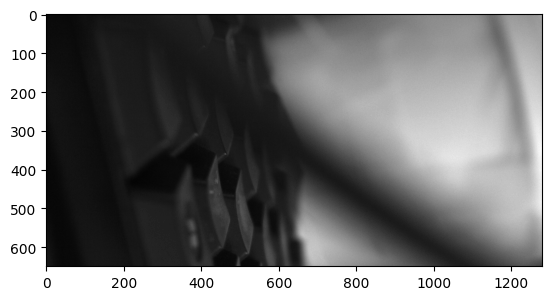

Program is closing...


In [2]:
# coding=utf-8
# =============================================================================
# Copyright (c) 2001-2023 FLIR Systems, Inc. All Rights Reserved.
#
# This software is the confidential and proprietary information of FLIR
# Integrated Imaging Solutions, Inc. ("Confidential Information"). You
# shall not disclose such Confidential Information and shall use it only in
# accordance with the terms of the license agreement you entered into
# with FLIR Integrated Imaging Solutions, Inc. (FLIR).
#
# FLIR MAKES NO REPRESENTATIONS OR WARRANTIES ABOUT THE SUITABILITY OF THE
# SOFTWARE, EITHER EXPRESSED OR IMPLIED, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR
# PURPOSE, OR NON-INFRINGEMENT. FLIR SHALL NOT BE LIABLE FOR ANY DAMAGES
# SUFFERED BY LICENSEE AS A RESULT OF USING, MODIFYING OR DISTRIBUTING
# THIS SOFTWARE OR ITS DERIVATIVES.
# =============================================================================
#
# This AcquireAndDisplay.py shows how to get the image data, and then display images in a GUI.
# This example relies on information provided in the ImageChannelStatistics.py example.
#
# This example demonstrates how to display images represented as numpy arrays.
# Currently, this program is limited to single camera use.
# NOTE: keyboard and matplotlib must be installed on Python interpreter prior to running this example.
#
# Please leave us feedback at: https://www.surveymonkey.com/r/TDYMVAPI
# More source code examples at: https://github.com/Teledyne-MV/Spinnaker-Examples
# Need help? Check out our forum at: https://teledynevisionsolutions.zendesk.com/hc/en-us/community/topics

import PySpin
import matplotlib.pyplot as plt
import sys
import keyboard

global continue_recording
continue_recording = True

def handle_close(evt):
    global continue_recording
    continue_recording = False

def acquire_and_display_images(cam, nodemap, nodemap_tldevice):
    global continue_recording

    sNodemap = cam.GetTLStreamNodeMap()

    # Change bufferhandling mode to NewestOnly
    node_bufferhandling_mode = PySpin.CEnumerationPtr(sNodemap.GetNode('StreamBufferHandlingMode'))
    if not PySpin.IsReadable(node_bufferhandling_mode) or not PySpin.IsWritable(node_bufferhandling_mode):
        print('Unable to set stream buffer handling mode.. Aborting...')
        return False

    node_newestonly = node_bufferhandling_mode.GetEntryByName('NewestOnly')
    if not PySpin.IsReadable(node_newestonly):
        print('Unable to set stream buffer handling mode.. Aborting...')
        return False

    node_newestonly_mode = node_newestonly.GetValue()
    node_bufferhandling_mode.SetIntValue(node_newestonly_mode)

    print('*** IMAGE ACQUISITION ***\n')
    try:
        node_acquisition_mode = PySpin.CEnumerationPtr(nodemap.GetNode('AcquisitionMode'))
        if not PySpin.IsReadable(node_acquisition_mode) or not PySpin.IsWritable(node_acquisition_mode):
            print('Unable to set acquisition mode to continuous (enum retrieval). Aborting...')
            return False

        node_acquisition_mode_continuous = node_acquisition_mode.GetEntryByName('Continuous')
        if not PySpin.IsReadable(node_acquisition_mode_continuous):
            print('Unable to set acquisition mode to continuous (entry retrieval). Aborting...')
            return False

        acquisition_mode_continuous = node_acquisition_mode_continuous.GetValue()
        node_acquisition_mode.SetIntValue(acquisition_mode_continuous)

        print('Acquisition mode set to continuous...')
        cam.BeginAcquisition()
        print('Acquiring images...')

        fig, ax = plt.subplots()

        fig.canvas.mpl_connect('close_event', handle_close)

        while continue_recording:
            try:
                image_result = cam.GetNextImage(1000)

                if image_result.IsIncomplete():
                    print('Image incomplete with image status %d ...' % image_result.GetImageStatus())
                else:
                    image_data = image_result.GetNDArray()
                    ax.imshow(image_data, cmap='gray')
                    plt.pause(0.1)  # Adjust pause interval if necessary
                    ax.cla()  # Clear axis instead of figure
                    if keyboard.is_pressed('ENTER'):
                        print('Program is closing...')
                        plt.close('all')
                        input('Done! Press Enter to exit...')
                        continue_recording = False

                image_result.Release()

            except PySpin.SpinnakerException as ex:
                print('Error: %s' % ex)
                return False

        cam.EndAcquisition()

    except PySpin.SpinnakerException as ex:
        print('Error: %s' % ex)
        return False

    return True

def run_single_camera(cam):
    try:
        result = True

        nodemap_tldevice = cam.GetTLDeviceNodeMap()

        cam.Init()
        nodemap = cam.GetNodeMap()

        result &= acquire_and_display_images(cam, nodemap, nodemap_tldevice)

        cam.DeInit()

    except PySpin.SpinnakerException as ex:
        print('Error: %s' % ex)
        result = False

    return result

def main():
    result = True

    system = PySpin.System.GetInstance()
    version = system.GetLibraryVersion()
    print('Library version: %d.%d.%d.%d' % (version.major, version.minor, version.type, version.build))

    cam_list = system.GetCameras()
    num_cameras = cam_list.GetSize()

    print('Number of cameras detected: %d' % num_cameras)

    if num_cameras == 0:
        cam_list.Clear()
        system.ReleaseInstance()
        print('Not enough cameras!')
        input('Done! Press Enter to exit...')
        return False

    for i, cam in enumerate(cam_list):
        print('Running example for camera %d...' % i)
        result &= run_single_camera(cam)
        print('Camera %d example complete... \n' % i)

    del cam
    cam_list.Clear()
    system.ReleaseInstance()
    input('Done! Press Enter to exit...')
    return result

if __name__ == '__main__':
    if main():
        sys.exit(0)
    else:
        sys.exit(1)


In [2]:
# ============================================================================

import os
import PySpin
import sys

NUM_IMAGES = 10  # number of images to grab

def acquire_images(cam_list):
    """
    This function acquires and saves 10 images from each device.

    :param cam_list: List of cameras
    :type cam_list: CameraList
    :return: True if successful, False otherwise.
    :rtype: bool
    """

    print('*** IMAGE ACQUISITION ***\n')
    try:
        result = True

        # Prepare each camera to acquire images
        #
        # *** NOTES ***
        # For pseudo-simultaneous streaming, each camera is prepared as if it
        # were just one, but in a loop. Notice that cameras are selected with
        # an index. We demonstrate pseduo-simultaneous streaming because true
        # simultaneous streaming would require multiple process or threads,
        # which is too complex for an example.
        #

        for i, cam in enumerate(cam_list):

            # Set acquisition mode to continuous
            node_acquisition_mode = PySpin.CEnumerationPtr(cam.GetNodeMap().GetNode('AcquisitionMode'))
            if not PySpin.IsReadable(node_acquisition_mode) or not PySpin.IsWritable(node_acquisition_mode):
                print('Unable to set acquisition mode to continuous (node retrieval; camera %d). Aborting... \n' % i)
                return False

            node_acquisition_mode_continuous = node_acquisition_mode.GetEntryByName('Continuous')
            if not PySpin.IsReadable(node_acquisition_mode_continuous):
                print('Unable to set acquisition mode to continuous (entry \'continuous\' retrieval %d). \
                Aborting... \n' % i)
                return False

            acquisition_mode_continuous = node_acquisition_mode_continuous.GetValue()

            node_acquisition_mode.SetIntValue(acquisition_mode_continuous)

            print('Camera %d acquisition mode set to continuous...' % i)

            # Begin acquiring images
            cam.BeginAcquisition()

            print('Camera %d started acquiring images...' % i)

            print()

        # Retrieve, convert, and save images for each camera
        #
        # *** NOTES ***
        # In order to work with simultaneous camera streams, nested loops are
        # needed. It is important that the inner loop be the one iterating
        # through the cameras; otherwise, all images will be grabbed from a
        # single camera before grabbing any images from another.

        # Create ImageProcessor instance for post processing images
        processor = PySpin.ImageProcessor()

        # Set default image processor color processing method
        #
        # *** NOTES ***
        # By default, if no specific color processing algorithm is set, the image
        # processor will default to NEAREST_NEIGHBOR method.
        processor.SetColorProcessing(PySpin.SPINNAKER_COLOR_PROCESSING_ALGORITHM_HQ_LINEAR)

        for n in range(NUM_IMAGES):
            for i, cam in enumerate(cam_list):
                try:
                    # Retrieve device serial number for filename
                    node_device_serial_number = PySpin.CStringPtr(cam.GetTLDeviceNodeMap().GetNode('DeviceSerialNumber'))

                    if PySpin.IsReadable(node_device_serial_number):
                        device_serial_number = node_device_serial_number.GetValue()
                        print('Camera %d serial number set to %s...' % (i, device_serial_number))

                    # Retrieve next received image and ensure image completion
                    image_result = cam.GetNextImage(1000)

                    if image_result.IsIncomplete():
                        print('Image incomplete with image status %d ... \n' % image_result.GetImageStatus())
                    else:
                        # Print image information
                        width = image_result.GetWidth()
                        height = image_result.GetHeight()
                        print('Camera %d grabbed image %d, width = %d, height = %d' % (i, n, width, height))

                        # Convert image to mono 8
                        image_converted = processor.Convert(image_result, PySpin.PixelFormat_Mono8)

                        # Create a unique filename
                        if device_serial_number:
                            filename = 'AcquisitionMultipleCamera-%s-%d.jpg' % (device_serial_number, n)
                        else:
                            filename = 'AcquisitionMultipleCamera-%d-%d.jpg' % (i, n)

                        # Save image
                        image_converted.Save(filename)
                        print('Image saved at %s' % filename)

                    # Release image
                    image_result.Release()
                    print()

                except PySpin.SpinnakerException as ex:
                    print('Error: %s' % ex)
                    result = False

        # End acquisition for each camera
        #
        # *** NOTES ***
        # Notice that what is usually a one-step process is now two steps
        # because of the additional step of selecting the camera. It is worth
        # repeating that camera selection needs to be done once per loop.
        #
        # It is possible to interact with cameras through the camera list with
        # GetByIndex(); this is an alternative to retrieving cameras as
        # CameraPtr objects that can be quick and easy for small tasks.
        for cam in cam_list:

            # End acquisition
            cam.EndAcquisition()

    except PySpin.SpinnakerException as ex:
        print('Error: %s' % ex)
        result = False

    return result


def print_device_info(nodemap, cam_num):
    """
    This function prints the device information of the camera from the transport
    layer; please see NodeMapInfo example for more in-depth comments on printing
    device information from the nodemap.

    :param nodemap: Transport layer device nodemap.
    :param cam_num: Camera number.
    :type nodemap: INodeMap
    :type cam_num: int
    :returns: True if successful, False otherwise.
    :rtype: bool
    """

    print('Printing device information for camera %d... \n' % cam_num)

    try:
        result = True
        node_device_information = PySpin.CCategoryPtr(nodemap.GetNode('DeviceInformation'))

        if PySpin.IsReadable(node_device_information):
            features = node_device_information.GetFeatures()
            for feature in features:
                node_feature = PySpin.CValuePtr(feature)
                print('%s: %s' % (node_feature.GetName(),
                                  node_feature.ToString() if PySpin.IsReadable(node_feature) else 'Node not readable'))

        else:
            print('Device control information not readable.')
        print()

    except PySpin.SpinnakerException as ex:
        print('Error: %s' % ex)
        return False

    return result

def run_multiple_cameras(cam_list):
    """
    This function acts as the body of the example; please see NodeMapInfo example
    for more in-depth comments on setting up cameras.

    :param cam_list: List of cameras
    :type cam_list: CameraList
    :return: True if successful, False otherwise.
    :rtype: bool
    """
    try:
        result = True

        # Retrieve transport layer nodemaps and print device information for
        # each camera
        # *** NOTES ***
        # This example retrieves information from the transport layer nodemap
        # twice: once to print device information and once to grab the device
        # serial number. Rather than caching the nodem#ap, each nodemap is
        # retrieved both times as needed.
        print('*** DEVICE INFORMATION ***\n')

        for i, cam in enumerate(cam_list):

            # Retrieve TL device nodemap
            nodemap_tldevice = cam.GetTLDeviceNodeMap()

            # Print device information
            result &= print_device_info(nodemap_tldevice, i)

        # Initialize each camera
        #
        # *** NOTES ***
        # You may notice that the steps in this function have more loops with
        # less steps per loop; this contrasts the AcquireImages() function
        # which has less loops but more steps per loop. This is done for
        # demonstrative purposes as both work equally well.
        #
        # *** LATER ***
        # Each camera needs to be deinitialized once all images have been
        # acquired.
        for i, cam in enumerate(cam_list):

            # Initialize camera
            cam.Init()

        # Acquire images on all cameras
        result &= acquire_images(cam_list)

        # Deinitialize each camera
        #
        # *** NOTES ***
        # Again, each camera must be deinitialized separately by first
        # selecting the camera and then deinitializing it.
        for cam in cam_list:

            # Deinitialize camera
            cam.DeInit()

        # Release reference to camera
        # NOTE: Unlike the C++ examples, we cannot rely on pointer objects being automatically
        # cleaned up when going out of scope.
        # The usage of del is preferred to assigning the variable to None.
        del cam

    except PySpin.SpinnakerException as ex:
        print('Error: %s' % ex)
        result = False

    return result


def main():
    """
    Example entry point; please see Enumeration example for more in-depth
    comments on preparing and cleaning up the system.

    :return: True if successful, False otherwise.
    :rtype: bool
    """

    # Since this application saves images in the current folder
    # we must ensure that we have permission to write to this folder.
    # If we do not have permission, fail right away.
    try:
        test_file = open('test.txt', 'w+')
    except IOError:
        print('Unable to write to current directory. Please check permissions.')
        input('Press Enter to exit...')
        return False

    test_file.close()
    os.remove(test_file.name)

    result = True

    # Retrieve singleton reference to system object
    system = PySpin.System.GetInstance()

    # Get current library version
    version = system.GetLibraryVersion()
    print('Library version: %d.%d.%d.%d' % (version.major, version.minor, version.type, version.build))

    # Retrieve list of cameras from the system
    cam_list = system.GetCameras()

    num_cameras = cam_list.GetSize()

    print('Number of cameras detected: %d' % num_cameras)

    # Finish if there are no cameras
    if num_cameras == 0:

        # Clear camera list before releasing system
        cam_list.Clear()

        # Release system instance
        system.ReleaseInstance()

        print('Not enough cameras!')
        input('Done! Press Enter to exit...')
        return False

    # Run example on all cameras
    print('Running example for all cameras...')

    result = run_multiple_cameras(cam_list)

    print('Example complete... \n')

    # Clear camera list before releasing system
    cam_list.Clear()

    # Release system instance
    system.ReleaseInstance()

    input('Done! Press Enter to exit...')
    return result

if __name__ == '__main__':
    if main():
        sys.exit(0)
    else:
        sys.exit(1)

Library version: 4.0.0.116
Number of cameras detected: 2
Running example for all cameras...
*** DEVICE INFORMATION ***

Printing device information for camera 0... 

DeviceID: USB\VID_1E10&PID_4000&MI_00\6&2A5D0DF9&0&0000_0
DeviceSerialNumber: 16290112
DeviceUserID: 
DeviceVendorName: FLIR
DeviceModelName: Blackfly S BFS-U3-13Y3M
DeviceVersion: 1808.0.120.0
DeviceBootloaderVersion: Node not readable
DeviceType: USB3Vision
DeviceDisplayName: FLIR Blackfly S BFS-U3-13Y3M
DeviceAccessStatus: OpenReadWrite
DeviceDriverVersion: PGRUSBCam3.sys : 2.7.3.249
DeviceIsUpdater: 0
DeviceInstanceId: USB\VID_1E10&PID_4000&MI_00\6&2A5D0DF9&0&0000
DeviceLocation: 0000.0014.0000.021.000.000.000.000.000
DeviceCurrentSpeed: SuperSpeed
DeviceU3VProtocol: 1
DevicePortId: 21
GenICamXMLLocation: Device
GenICamXMLPath: 
GUIXMLLocation: Device
GUIXMLPath: Input.xml

Printing device information for camera 1... 

DeviceID: USB\VID_1E10&PID_4000&MI_00\6&B540B48&0&0000_0
DeviceSerialNumber: 16290104
DeviceUserID: 


SystemExit: 0